In [99]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, pairwise
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import seaborn as sns
import matplotlib.pylab as plt
from prettytable import PrettyTable
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import classificationSummary, gainsChart, liftChart
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba.metric import AIC_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
%matplotlib inline

## Data Pre-Processing

In [164]:
# Load the fraud_orcale dataset
data=pd.read_csv('fraud_oracle.csv')
data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [165]:
data.shape

(15420, 33)

In [166]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [167]:
# Find missing value
cols_to_check = ['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy']

# Check for missing values in the selected columns
missing_values = data[cols_to_check].isnull().sum()

# Print the result
print(missing_values)

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64


In [168]:
#check duplicates
duplicates = data.duplicated()
print(data[duplicates])

Empty DataFrame
Columns: [Month, WeekOfMonth, DayOfWeek, Make, AccidentArea, DayOfWeekClaimed, MonthClaimed, WeekOfMonthClaimed, Sex, MaritalStatus, Age, Fault, PolicyType, VehicleCategory, VehiclePrice, FraudFound_P, PolicyNumber, RepNumber, Deductible, DriverRating, Days_Policy_Accident, Days_Policy_Claim, PastNumberOfClaims, AgeOfVehicle, AgeOfPolicyHolder, PoliceReportFiled, WitnessPresent, AgentType, NumberOfSuppliments, AddressChange_Claim, NumberOfCars, Year, BasePolicy]
Index: []

[0 rows x 33 columns]


In [169]:
# Examine value for certain category variables
value_counts_dict = {}

columns_to_count = ['Month', 'Make', 'AccidentArea', 'MonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy']

for column in columns_to_count:
    value_counts_dict[column] = data[column].value_counts().to_dict()

# Print the value counts dictionary for each specified column
for column, value_counts in value_counts_dict.items():
    print(f"Value counts for {column}:\n{value_counts}\n")

Value counts for Month:
{'Jan': 1411, 'May': 1367, 'Mar': 1360, 'Jun': 1321, 'Oct': 1305, 'Dec': 1285, 'Apr': 1280, 'Feb': 1266, 'Jul': 1257, 'Sep': 1240, 'Nov': 1201, 'Aug': 1127}

Value counts for Make:
{'Pontiac': 3837, 'Toyota': 3121, 'Honda': 2801, 'Mazda': 2354, 'Chevrolet': 1681, 'Accura': 472, 'Ford': 450, 'VW': 283, 'Dodge': 109, 'Saab': 108, 'Mercury': 83, 'Saturn': 58, 'Nisson': 30, 'BMW': 15, 'Jaguar': 6, 'Porche': 5, 'Mecedes': 4, 'Ferrari': 2, 'Lexus': 1}

Value counts for AccidentArea:
{'Urban': 13822, 'Rural': 1598}

Value counts for MonthClaimed:
{'Jan': 1446, 'May': 1411, 'Mar': 1348, 'Oct': 1339, 'Jun': 1293, 'Feb': 1287, 'Nov': 1285, 'Apr': 1271, 'Sep': 1242, 'Jul': 1225, 'Dec': 1146, 'Aug': 1126, '0': 1}

Value counts for Sex:
{'Male': 13000, 'Female': 2420}

Value counts for MaritalStatus:
{'Married': 10625, 'Single': 4684, 'Divorced': 76, 'Widow': 35}

Value counts for Age:
{30: 596, 33: 574, 34: 573, 35: 569, 28: 560, 29: 552, 31: 550, 32: 544, 27: 540, 26: 535,

In [170]:
#Drop columns based on Examine value for certain category variables and information of dataset
data = data.drop (columns=['WeekOfMonth','PolicyType','PolicyNumber','RepNumber','DayOfWeek',
                           'WeekOfMonthClaimed','DayOfWeekClaimed','Year'])
data.columns

Index(['Month', 'Make', 'AccidentArea', 'MonthClaimed', 'Sex', 'MaritalStatus',
       'Age', 'Fault', 'VehicleCategory', 'VehiclePrice', 'FraudFound_P',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'BasePolicy'],
      dtype='object')

In [171]:
#Drop rows where 'Age' and 'MonthClaimed' is '0', 'Days_Policy_Accident' and 'Days_Policy_Claim' is 'none'
data = data[data['Age'] != 0]
data = data[data['MonthClaimed'] != 0]
data = data[data['Days_Policy_Accident']!= 'none']
data = data[data['Days_Policy_Claim']!= 'none']

In [172]:
# Examine value for certain category variables
value_counts_dict = {}

columns_to_count = ['Age', 'MonthClaimed', 'Days_Policy_Accident', 'Days_Policy_Claim']

for column in columns_to_count:
    value_counts_dict[column] = data[column].value_counts().to_dict()

# Print the value counts dictionary for each specified column
for column, value_counts in value_counts_dict.items():
    print(f"Value counts for {column}:\n{value_counts}\n")

Value counts for Age:
{30: 594, 33: 571, 34: 569, 35: 568, 28: 559, 31: 550, 29: 550, 32: 543, 27: 536, 26: 533, 39: 432, 41: 419, 44: 410, 37: 409, 36: 406, 43: 403, 42: 400, 45: 383, 38: 382, 40: 382, 47: 305, 46: 293, 50: 290, 54: 288, 48: 288, 55: 281, 51: 278, 52: 276, 49: 263, 53: 252, 60: 156, 64: 146, 56: 146, 61: 145, 57: 144, 59: 138, 63: 136, 24: 135, 65: 135, 58: 134, 21: 126, 22: 125, 23: 120, 62: 112, 25: 104, 18: 47, 72: 45, 76: 42, 66: 42, 71: 40, 78: 35, 74: 35, 75: 34, 69: 32, 19: 32, 68: 32, 80: 32, 73: 32, 67: 31, 77: 29, 20: 28, 70: 27, 79: 20, 16: 9, 17: 6}

Value counts for MonthClaimed:
{'May': 1373, 'Jan': 1370, 'Oct': 1333, 'Mar': 1290, 'Nov': 1272, 'Jun': 1265, 'Feb': 1235, 'Sep': 1233, 'Apr': 1213, 'Jul': 1211, 'Dec': 1134, 'Aug': 1116}

Value counts for Days_Policy_Accident:
{'more than 30': 14927, '8 to 15': 55, '15 to 30': 49, '1 to 7': 14}

Value counts for Days_Policy_Claim:
{'more than 30': 14986, '15 to 30': 45, '8 to 15': 14}



In [173]:
data.describe()

,Age,FraudFound_P,Deductible,DriverRating
count,15045.000000,15045.000000,15045.000000,15045.000000
mean,40.711466,0.058691,407.889664,2.489266
std,12.318711,0.235053,44.457121,1.120544
min,16.000000,0.000000,300.000000,1.000000
25%,31.000000,0.000000,400.000000,1.000000
50%,39.000000,0.000000,400.000000,2.000000
75%,49.000000,0.000000,400.000000,3.000000
max,80.000000,1.000000,700.000000,4.000000


## Variable Choose

In [174]:
# Save a csv file
data.to_csv("data1.csv", index=False)
CM_df = pd.read_csv('data1.csv')
CM_df.head()

,Month,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,VehicleCategory,VehiclePrice,...,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Dec,Honda,Urban,Jan,Female,Single,21,Policy Holder,Sport,more than 69000,...,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability
1,Jan,Honda,Urban,Jan,Male,Single,34,Policy Holder,Sport,more than 69000,...,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision
2,Oct,Honda,Urban,Nov,Male,Married,47,Policy Holder,Sport,more than 69000,...,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision
3,Jun,Toyota,Rural,Jul,Male,Married,65,Third Party,Sport,20000 to 29000,...,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability
4,Jan,Honda,Urban,Feb,Female,Single,27,Third Party,Sport,more than 69000,...,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision


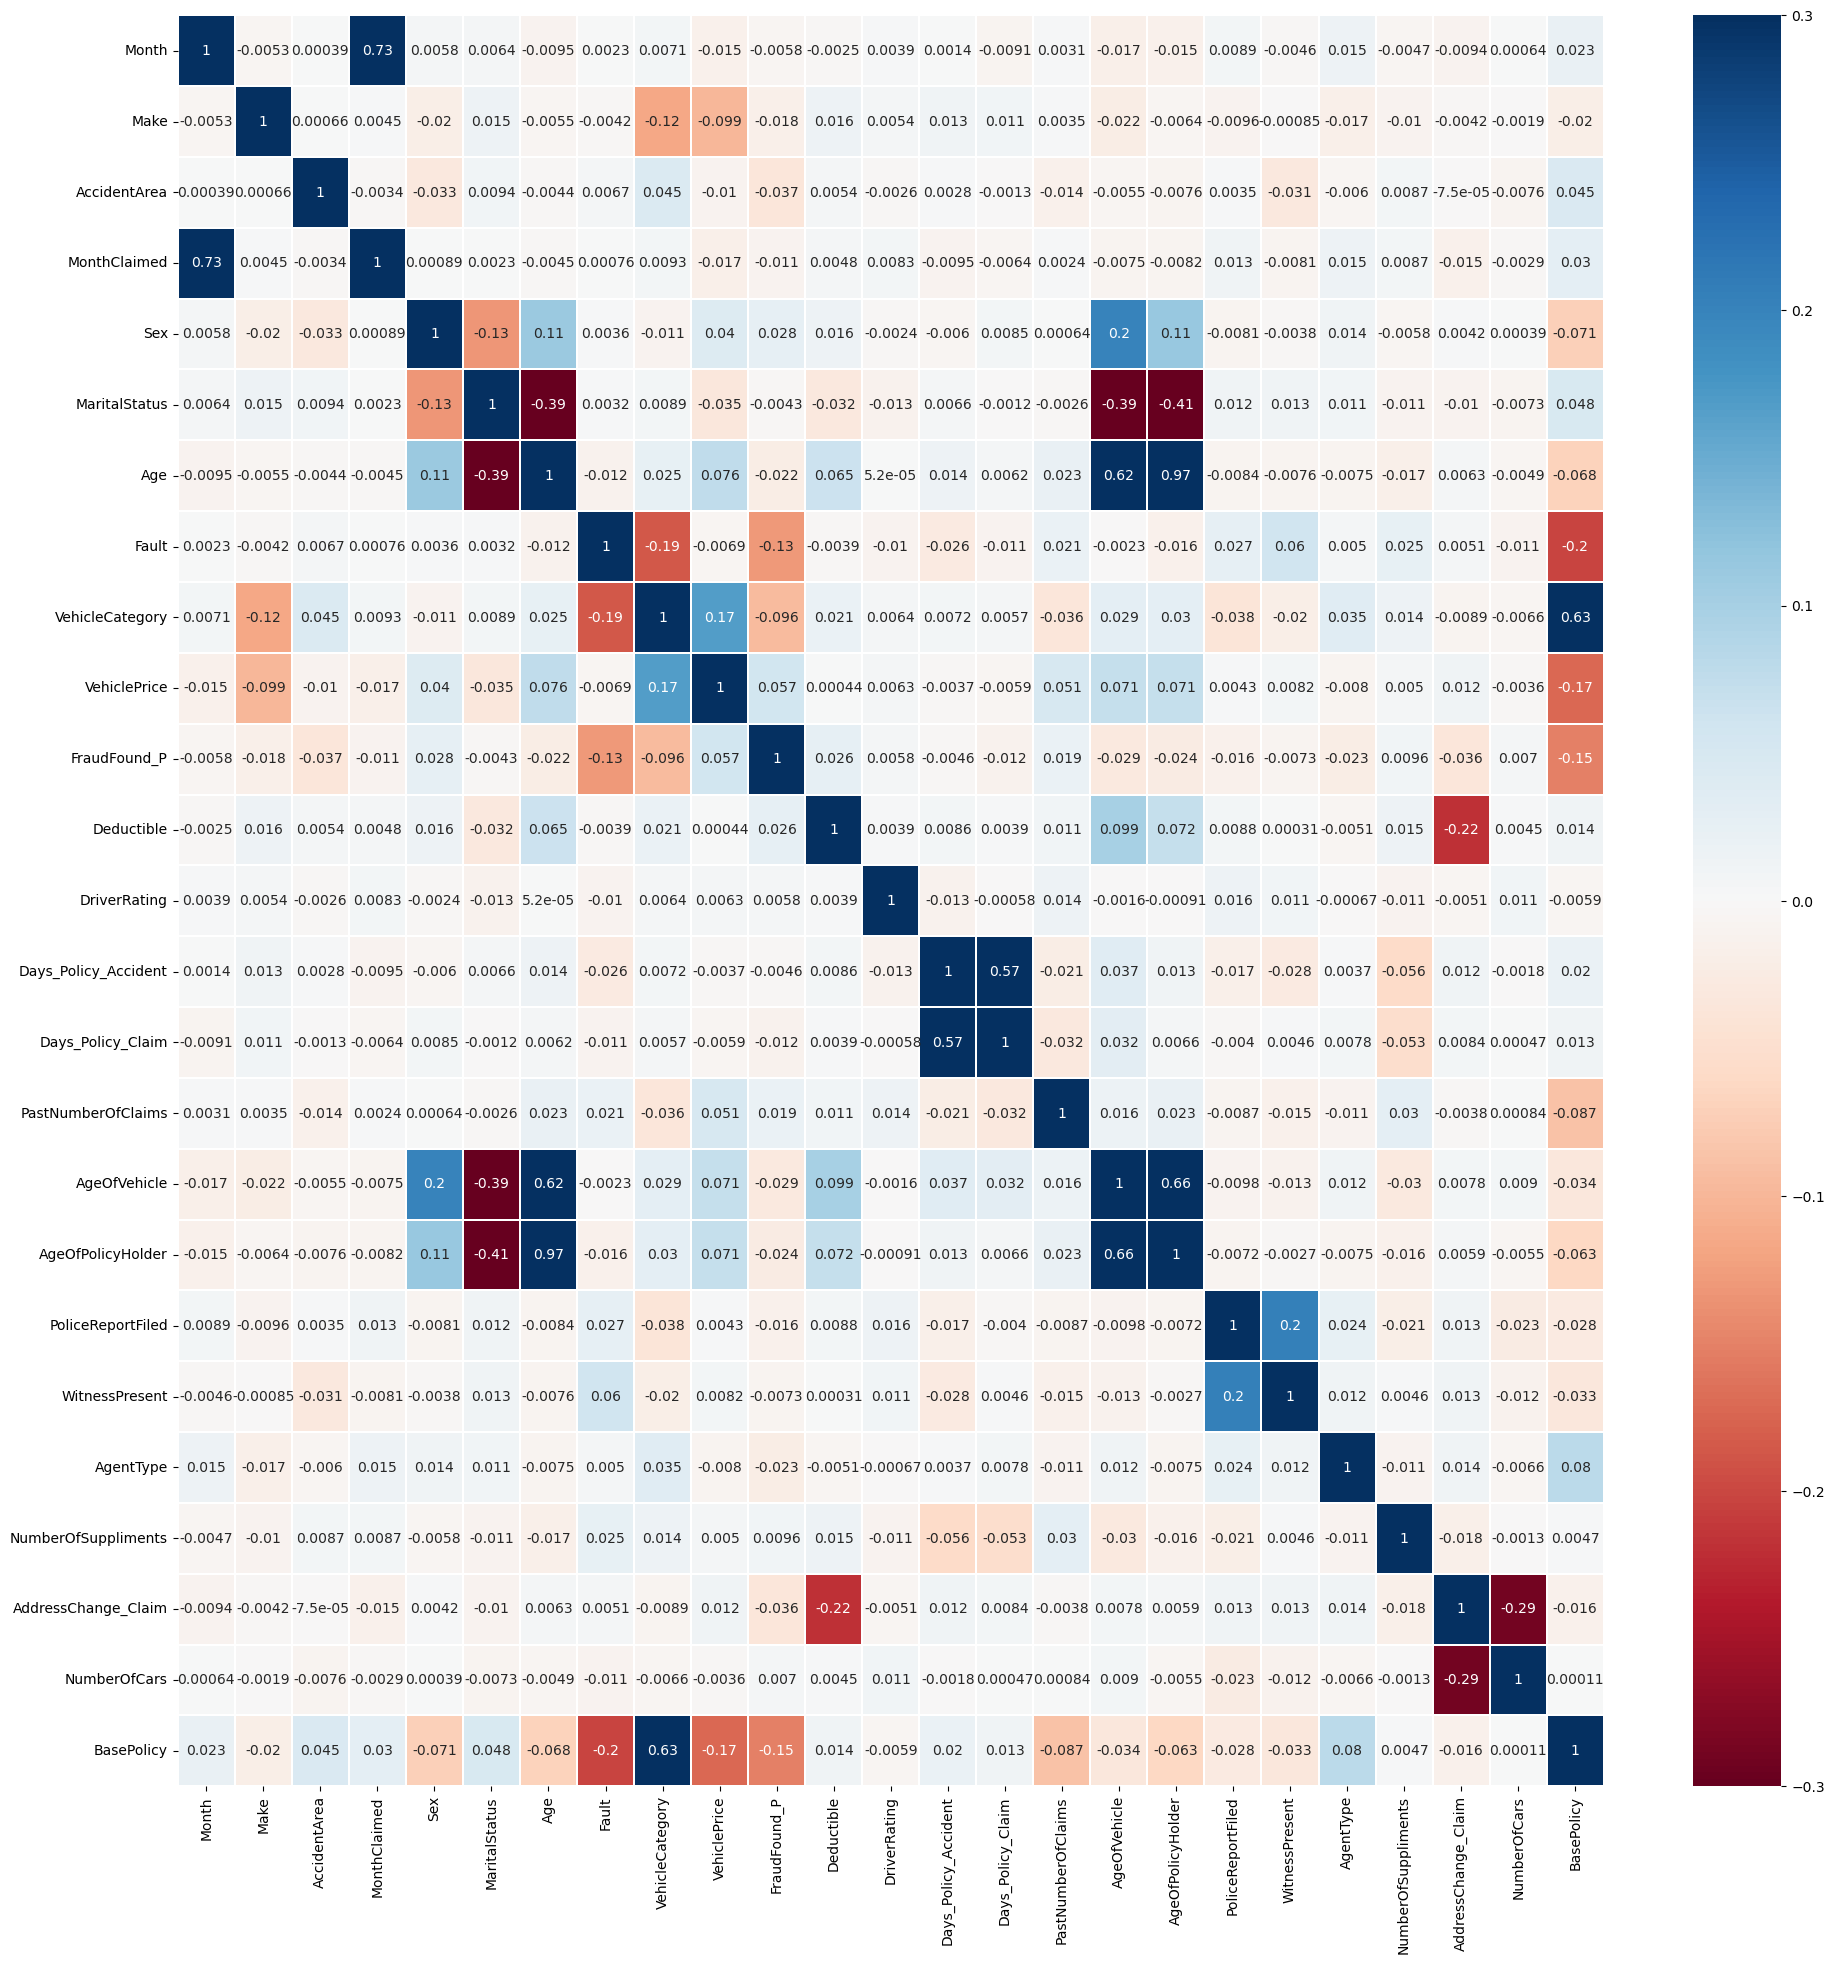

In [175]:
# Correlation Matrix
labelencoder=LabelEncoder()
for column in CM_df.columns:
    CM_df[column] = labelencoder.fit_transform(CM_df[column])

plt.figure(figsize=(23,23))
sns.heatmap(CM_df.corr(),linewidths=.1,vmin=-0.3, vmax=0.3,cmap="RdBu", annot=True)
plt.yticks(rotation=0);

In [176]:
# Drop columns based on Correlation Matrix
data = data.drop(columns=['Month','MonthClaimed','MaritalStatus', 'DriverRating', 'WitnessPresent',
                      'Days_Policy_Accident','NumberOfCars'])
data.columns

Index(['Make', 'AccidentArea', 'Sex', 'Age', 'Fault', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'Deductible', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'BasePolicy'],
      dtype='object')

In [177]:
data.head()

,Make,AccidentArea,Sex,Age,Fault,VehicleCategory,VehiclePrice,FraudFound_P,Deductible,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,AgentType,NumberOfSuppliments,AddressChange_Claim,BasePolicy
0,Honda,Urban,Female,21,Policy Holder,Sport,more than 69000,0,300,more than 30,none,3 years,26 to 30,No,External,none,1 year,Liability
1,Honda,Urban,Male,34,Policy Holder,Sport,more than 69000,0,400,more than 30,none,6 years,31 to 35,Yes,External,none,no change,Collision
2,Honda,Urban,Male,47,Policy Holder,Sport,more than 69000,0,400,more than 30,1,7 years,41 to 50,No,External,none,no change,Collision
3,Toyota,Rural,Male,65,Third Party,Sport,20000 to 29000,0,400,more than 30,1,more than 7,51 to 65,Yes,External,more than 5,no change,Liability
4,Honda,Urban,Female,27,Third Party,Sport,more than 69000,0,400,more than 30,none,5 years,31 to 35,No,External,none,no change,Collision


## Resample data (20% from non_fraud  or  1.5 times fraud)

In [178]:
# Class count
count_class_0, count_class_1 = data.FraudFound_P.value_counts()

# Divide by class
non_fraud = data[data['FraudFound_P'] == 0]
fraud = data[data['FraudFound_P'] == 1]

In [179]:
# Resample the non_fraud samples to get 20% of them
non_fraud_resample = resample(non_fraud, replace= False,
                              n_samples=int(0.2 * len(non_fraud)))
# resample_df contains resample dataset with non-reproducible random samplings
resample_df = pd.concat ([non_fraud_resample,fraud])

In [180]:
fraud_counts= resample_df['FraudFound_P'].value_counts()
fraud_counts

0    2832
1     883
Name: FraudFound_P, dtype: int64

In [181]:
# Save a csv file
resample_df.to_csv("df.csv", index=False)
df = pd.read_csv('df.csv')
df.head()

,Make,AccidentArea,Sex,Age,Fault,VehicleCategory,VehiclePrice,FraudFound_P,Deductible,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,AgentType,NumberOfSuppliments,AddressChange_Claim,BasePolicy
0,Honda,Urban,Male,44,Policy Holder,Sedan,20000 to 29000,0,400,more than 30,none,7 years,36 to 40,No,External,none,no change,Collision
1,Pontiac,Urban,Male,31,Policy Holder,Sport,20000 to 29000,0,400,more than 30,2 to 4,6 years,31 to 35,No,External,more than 5,no change,Liability
2,Chevrolet,Urban,Male,52,Policy Holder,Utility,more than 69000,0,400,more than 30,1,more than 7,41 to 50,No,External,none,no change,All Perils
3,Honda,Urban,Male,37,Policy Holder,Sedan,20000 to 29000,0,400,more than 30,more than 4,7 years,36 to 40,No,External,1 to 2,no change,Collision
4,Mazda,Urban,Male,35,Policy Holder,Sport,20000 to 29000,0,400,more than 30,2 to 4,6 years,31 to 35,No,External,none,no change,Liability


In [182]:
df.columns

Index(['Make', 'AccidentArea', 'Sex', 'Age', 'Fault', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'Deductible', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'BasePolicy'],
      dtype='object')

## Visualization

In [119]:
# Value counts of the 'FraudFound_P':'0' represents no fraud, '1' represents fraud
fraud_counts= df['FraudFound_P'].value_counts()
fraud_counts

0    2832
1     883
Name: FraudFound_P, dtype: int64

In [120]:
# The percentage of Fraud Cases
fraud_total_counts= len(df['FraudFound_P'])
fraud_case = df['FraudFound_P'].sum()
frand_percentage = (fraud_case /fraud_total_counts) *100
frand_percentage

23.768506056527592

In [121]:
# the Mean for each group
df.groupby('FraudFound_P').mean()

/var/folders/t3/zzjb29hx2qv6z9yl0rs0cpz80000gn/T/ipykernel_17273/637699691.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('FraudFound_P').mean()


,Age,Deductible
FraudFound_P,,
0,40.546257,407.203390
1,39.627407,411.098528


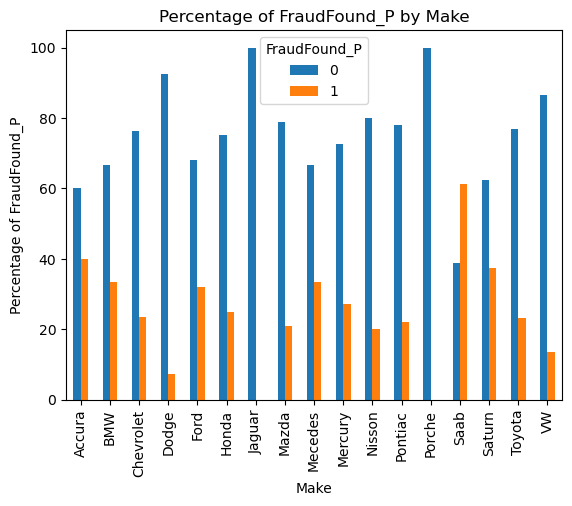

In [122]:
# Percentage of FraudFound_P by Make
make_fraud = pd.crosstab(df['Make'], df['FraudFound_P'], normalize='index') * 100
make_fraud.plot(kind='bar', stacked=False)
plt.xlabel('Make')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by Make')

plt.show()

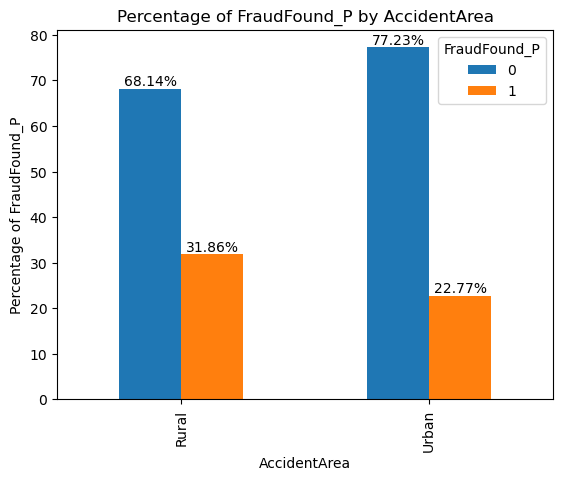

In [123]:
# Percentage of FraudFound_P by AccidentArea
accidentarea_fraud = pd.crosstab(df['AccidentArea'], df['FraudFound_P'], normalize='index') * 100
ax = accidentarea_fraud.plot(kind='bar', stacked=False)

plt.xlabel('AccidentArea')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by AccidentArea')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()


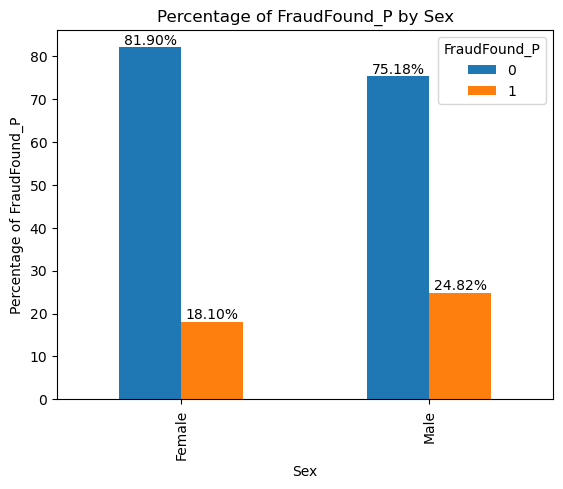

In [124]:
# Percentage of FraudFound_P by Sex
sex_fraud = pd.crosstab(df['Sex'], df['FraudFound_P'], normalize='index') * 100
ax = sex_fraud.plot(kind='bar', stacked=False)

plt.xlabel('Sex')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by Sex')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

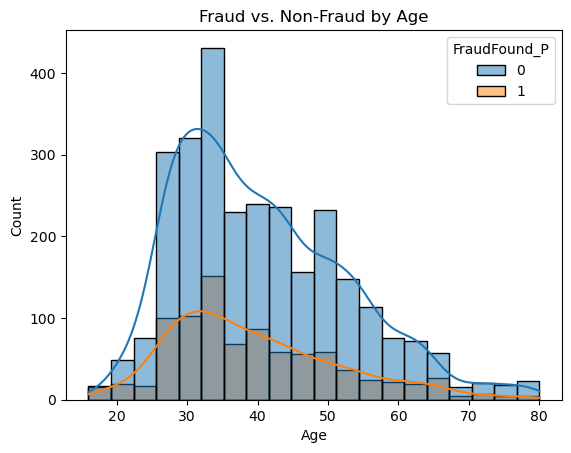

In [125]:
# the numbers of Fraud vs. Non-Fraud by Age
sns.histplot(data=df, x='Age', hue='FraudFound_P', bins=20, kde=True)
plt.title('Fraud vs. Non-Fraud by Age')
plt.show()

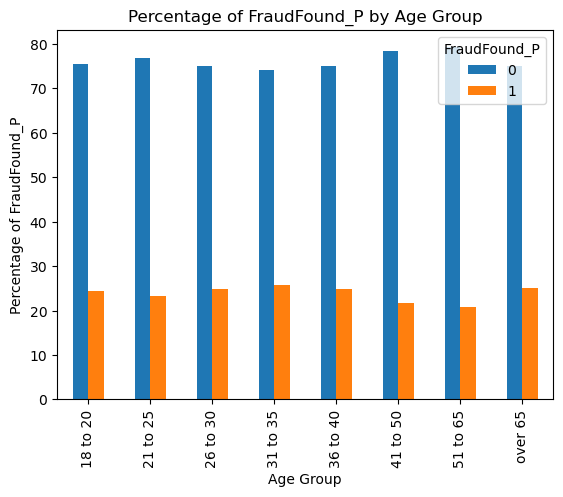

In [126]:
# Percentage of FraudFound_P by Age Group
# Define Age bins
Age_bins = [18,21,26,31,36,41,51,65, df['Age'].max()]
# Create Age groups
Age_labels = ['18 to 20', '21 to 25', '26 to 30','31 to 35','36 to 40', '41 to 50', '51 to 65','over 65']
df['AgeGroup'] = pd.cut(df['Age'], bins=Age_bins, labels=Age_labels)

# Create bar plot
Age_fraud = pd.crosstab(df['AgeGroup'], df['FraudFound_P'], normalize='index') * 100
Age_fraud.plot(kind='bar', stacked=False)
plt.xlabel('Age Group')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by Age Group')
plt.show()

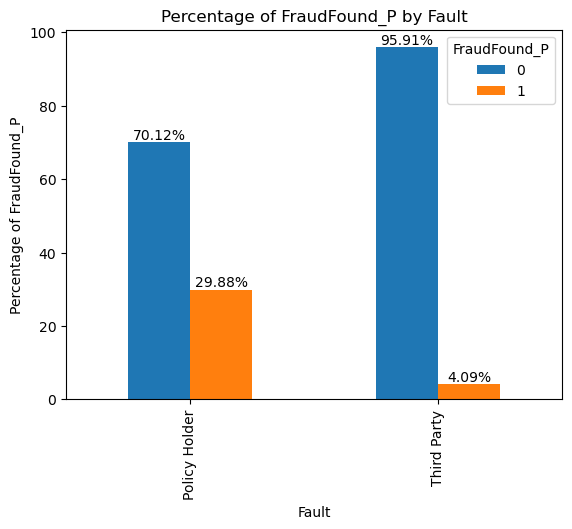

In [127]:
# Percentage of FraudFound_P by Fault
Fault_fraud = pd.crosstab(df['Fault'], df['FraudFound_P'], normalize='index') * 100
ax = Fault_fraud.plot(kind='bar', stacked=False)

plt.xlabel('Fault')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by Fault')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

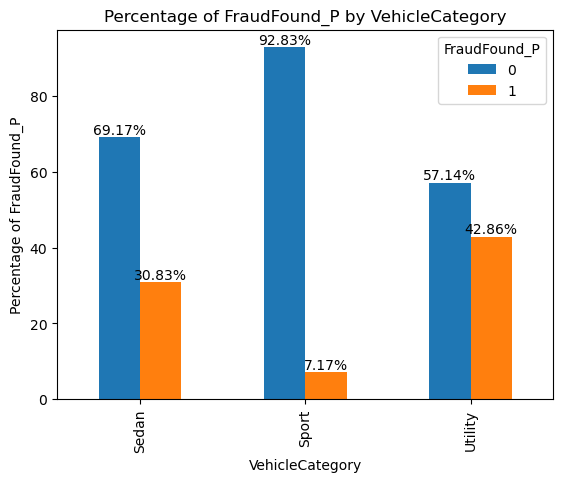

In [128]:
# Percentage of FraudFound_P by VehicleCategory
VehicleCategory_fraud = pd.crosstab(df['VehicleCategory'], df['FraudFound_P'], normalize='index') * 100
ax = VehicleCategory_fraud.plot(kind='bar', stacked=False)

plt.xlabel('VehicleCategory')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by VehicleCategory')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

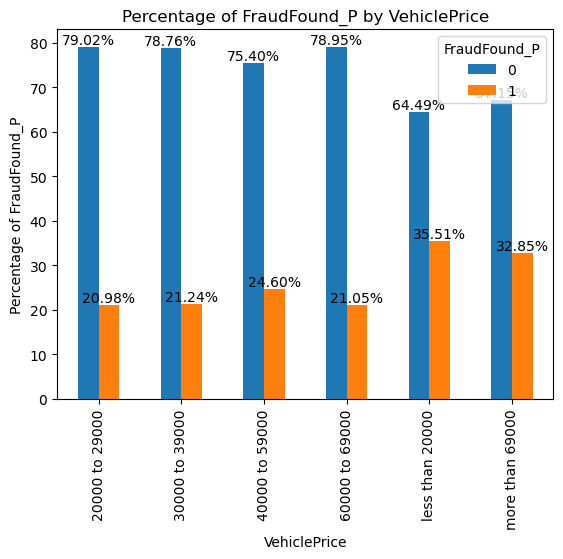

In [129]:
# Percentage of FraudFound_P by VehiclePrice
VehiclePrice_fraud = pd.crosstab(df['VehiclePrice'], df['FraudFound_P'], normalize='index') * 100
ax = VehiclePrice_fraud.plot(kind='bar', stacked=False)

plt.xlabel('VehiclePrice')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by VehiclePrice')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

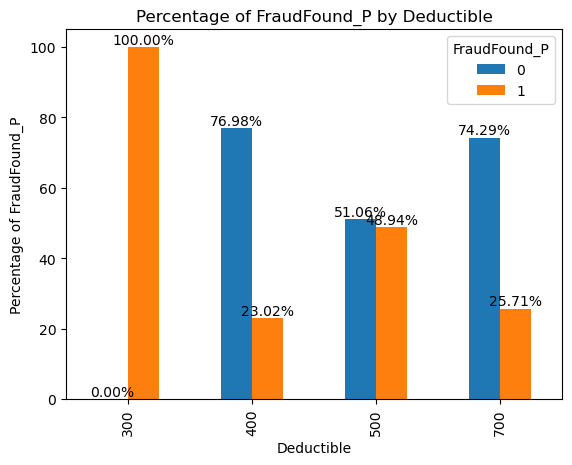

In [130]:
# Percentage of FraudFound_P by Deductible
Deductible_fraud = pd.crosstab(df['Deductible'], df['FraudFound_P'], normalize='index') * 100
ax = Deductible_fraud.plot(kind='bar', stacked=False)

plt.xlabel('Deductible')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by Deductible')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

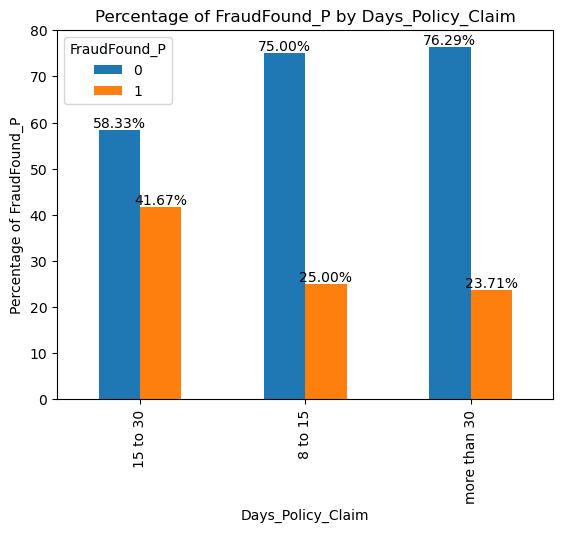

In [131]:
# Percentage of FraudFound_P by Days_Policy_Claim
Days_Policy_Claim_fraud = pd.crosstab(df['Days_Policy_Claim'], df['FraudFound_P'], normalize='index') * 100
ax = Days_Policy_Claim_fraud.plot(kind='bar', stacked=False)

plt.xlabel('Days_Policy_Claim')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by Days_Policy_Claim')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

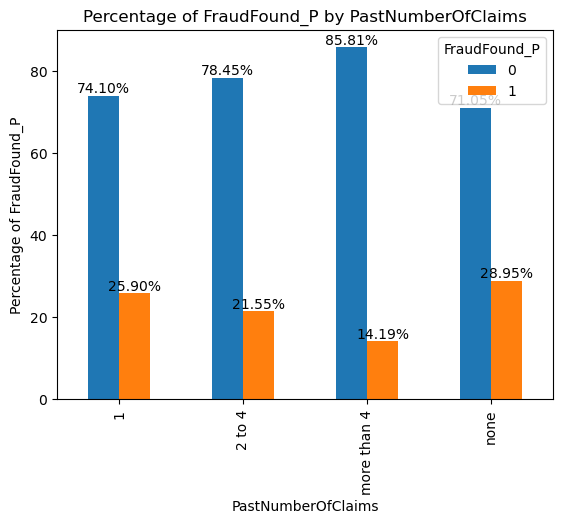

In [132]:
# Percentage of FraudFound_P by PastNumberOfClaims
PastNumberOfClaims_fraud = pd.crosstab(df['PastNumberOfClaims'], df['FraudFound_P'], normalize='index') * 100
ax = PastNumberOfClaims_fraud.plot(kind='bar', stacked=False)

plt.xlabel('PastNumberOfClaims')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by PastNumberOfClaims')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

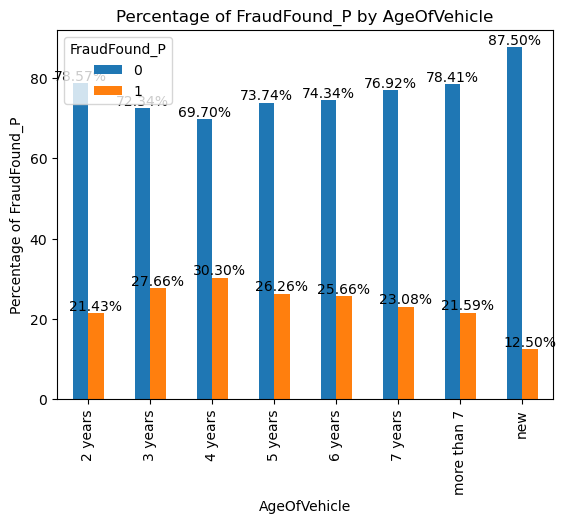

In [133]:
# Percentage of FraudFound_P by AgeOfVehicle
AgeOfVehicle_fraud = pd.crosstab(df['AgeOfVehicle'], df['FraudFound_P'], normalize='index') * 100
ax = AgeOfVehicle_fraud.plot(kind='bar', stacked=False)

plt.xlabel('AgeOfVehicle')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by AgeOfVehicle')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

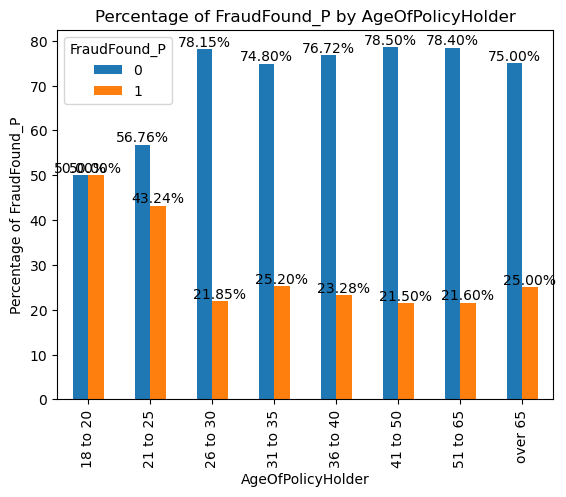

In [134]:
# Percentage of FraudFound_P by AgeOfPolicyHolder
AgeOfPolicyHolder_fraud = pd.crosstab(df['AgeOfPolicyHolder'], df['FraudFound_P'], normalize='index') * 100
ax = AgeOfPolicyHolder_fraud.plot(kind='bar', stacked=False)

plt.xlabel('AgeOfPolicyHolder')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by AgeOfPolicyHolder')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

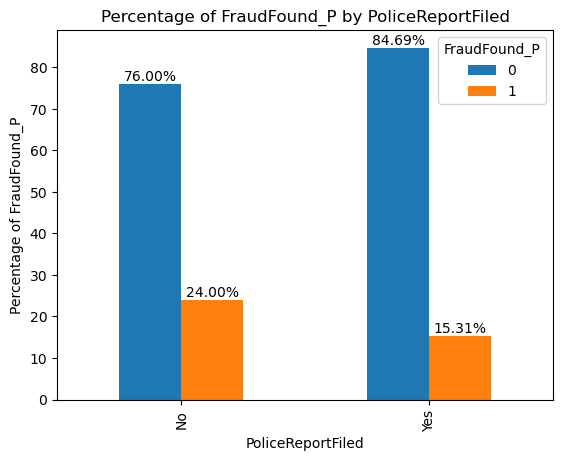

In [135]:
# Percentage of FraudFound_P based on if the incident was reported to the police or not
PoliceReportFiled_fraud = pd.crosstab(df['PoliceReportFiled'], df['FraudFound_P'], normalize='index') * 100
ax = PoliceReportFiled_fraud.plot(kind='bar', stacked=False)

plt.xlabel('PoliceReportFiled')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by PoliceReportFiled')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

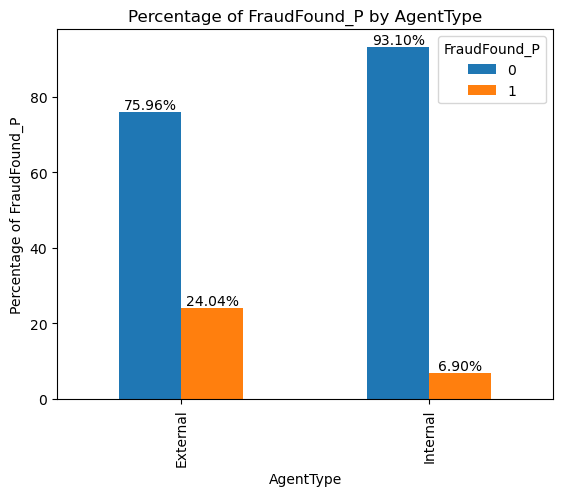

In [136]:
# Percentage of FraudFound_P by AgentType
AgentType_fraud = pd.crosstab(df['AgentType'], df['FraudFound_P'], normalize='index') * 100
ax = AgentType_fraud.plot(kind='bar', stacked=False)

plt.xlabel('AgentType')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by AgentType')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

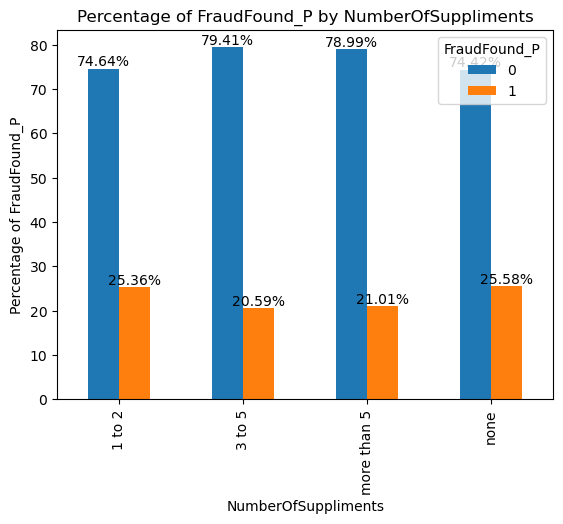

In [137]:
# Percentage of FraudFound_P by NumberOfSuppliments
NumberOfSuppliments_fraud = pd.crosstab(df['NumberOfSuppliments'], df['FraudFound_P'], normalize='index') * 100
ax = NumberOfSuppliments_fraud.plot(kind='bar', stacked=False)

plt.xlabel('NumberOfSuppliments')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by NumberOfSuppliments')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

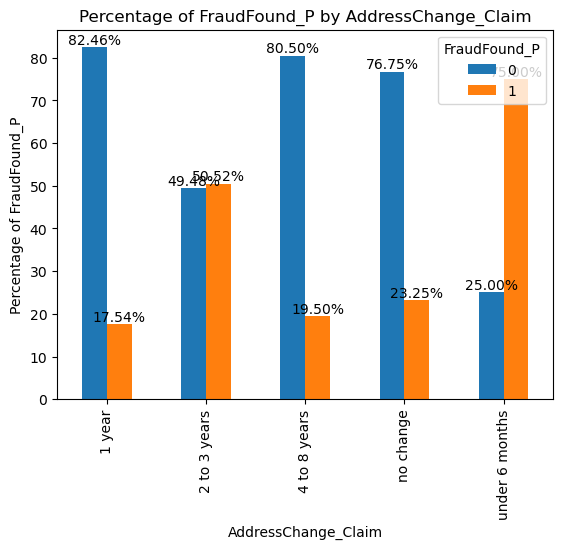

In [138]:
# Percentage of FraudFound_P by AddressChange_Claim
AddressChange_Claim_fraud = pd.crosstab(df['AddressChange_Claim'], df['FraudFound_P'], normalize='index') * 100
ax = AddressChange_Claim_fraud.plot(kind='bar', stacked=False)

plt.xlabel('AddressChange_Claim')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by AddressChange_Claim')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

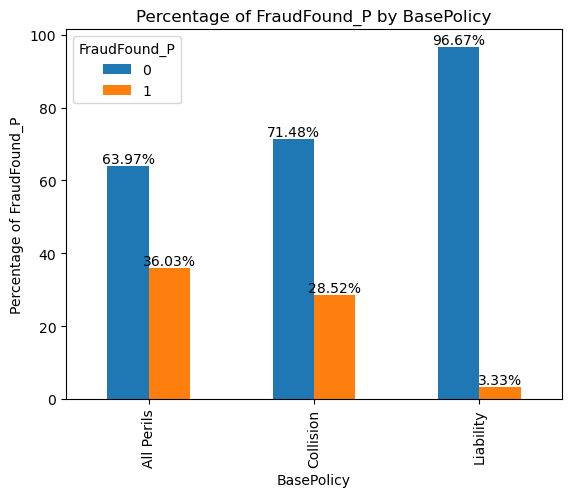

In [139]:
# Percentage of FraudFound_P by BasePolicy
BasePolicy_fraud = pd.crosstab(df['BasePolicy'], df['FraudFound_P'], normalize='index') * 100
ax = BasePolicy_fraud.plot(kind='bar', stacked=False)

plt.xlabel('BasePolicy')
plt.ylabel('Percentage of FraudFound_P')
plt.title('Percentage of FraudFound_P by BasePolicy')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

# One class SVM

In [140]:
# Data frame with normal observation
nor_obs = CM_df.loc[CM_df.FraudFound_P==0]    
# Data frame with anomaly observation
ano_obs = CM_df.loc[CM_df.FraudFound_P==1]    

In [141]:
X_nor_obs = nor_obs.drop('FraudFound_P', axis=1)
y_nor_obs = nor_obs['FraudFound_P']

X_ano_obs = ano_obs.drop('FraudFound_P', axis=1)
y_ano_obs = ano_obs['FraudFound_P']

X = X_nor_obs.append(X_ano_obs)
y = y_nor_obs.append(y_ano_obs)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


/var/folders/t3/zzjb29hx2qv6z9yl0rs0cpz80000gn/T/ipykernel_17273/2792750505.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X_nor_obs.append(X_ano_obs)
/var/folders/t3/zzjb29hx2qv6z9yl0rs0cpz80000gn/T/ipykernel_17273/2792750505.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y_nor_obs.append(y_ano_obs)


In [142]:
one_class_svm = OneClassSVM(nu=0.01, kernel = 'linear', gamma = 'auto').fit(X_train)

In [143]:
prediction = one_class_svm.predict(X_test)
prediction = [1 if i==-1 else 0 for i in prediction]
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5682
           1       0.10      0.02      0.03       336

    accuracy                           0.93      6018
   macro avg       0.52      0.50      0.50      6018
weighted avg       0.90      0.93      0.91      6018



In [144]:
# Confusion Matrix
classificationSummary(y_test, prediction)

Confusion Matrix (Accuracy 0.9347)

       Prediction
Actual    0    1
     0 5618   64
     1  329    7


In [145]:
# Confusion Matrix
cmocsvm = [[5618, 64], [329, 7]]


# For conf_matrix1
TPocsvm = cmocsvm[1][1]
FNocsvm = cmocsvm[1][0]
TNocsvm = cmocsvm[0][0]
FPocsvm = cmocsvm[0][1]

TPocsvm = (TPocsvm / (TPocsvm + FNocsvm)) * 100
TNocsvm = (TNocsvm / (TNocsvm + FPocsvm)) * 100

# Define the headers and data for the table
headers = ['Confusion Matrix', 'Sensitivity (%)','Specificity (%)','Total Accuracy (%)']
data = [['cmocsvm', 
         '{:.2f}%'.format(TPocsvm), 
         '{:.2f}%'.format(TNocsvm),
         '{:.2f}%'.format((cmocsvm[0][0] + cmocsvm[1][1])/(cmocsvm[0][0] + cmocsvm[0][1] + cmocsvm[1][0] + cmocsvm[1][1]) * 100)]
]

# Create the table and set the headers
table = PrettyTable()
table.field_names = headers

# Add the data to the table
for row in data:
    table.add_row(row)

# Print the table
print(table)

+------------------+-----------------+-----------------+--------------------+
| Confusion Matrix | Sensitivity (%) | Specificity (%) | Total Accuracy (%) |
+------------------+-----------------+-----------------+--------------------+
|     cmocsvm      |      2.08%      |      98.87%     |       93.47%       |
+------------------+-----------------+-----------------+--------------------+


# Isolation Forest

In [146]:
if_model = IsolationForest(n_estimators=100, random_state=0).fit(X_train)
# Predict the anomalies
if_prediction = if_model.predict(X_test)
# Change the anomalies' values to make it consistent with the true values
if_prediction = [1 if i==-1 else 0 for i in if_prediction]
# Check the model performance
print(classification_report(y_test, if_prediction))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      5682
           1       0.07      0.20      0.10       336

    accuracy                           0.80      6018
   macro avg       0.51      0.52      0.49      6018
weighted avg       0.90      0.80      0.84      6018



In [147]:
# Confusion Matrix
classificationSummary(y_test, if_prediction)

Confusion Matrix (Accuracy 0.7991)

       Prediction
Actual    0    1
     0 4743  939
     1  270   66


In [148]:
# Confusion Matrix
cmif = [[4743, 939], [270, 66]]


# For conf_matrix1
TPif = cmif[1][1]
FNif = cmif[1][0]
TNif = cmif[0][0]
FPif = cmif[0][1]

TPif = (TPif / (TPif + FNif)) * 100
TNif = (TNif / (TNif + FPif)) * 100

# Define the headers and data for the table
headers = ['Confusion Matrix', 'Sensitivity (%)','Specificity (%)','Total Accuracy (%)']
data = [['cmocsvm', 
         '{:.2f}%'.format(TPif), 
         '{:.2f}%'.format(TNif),
         '{:.2f}%'.format((cmif[0][0] + cmif[1][1])/(cmif[0][0] + cmif[0][1] + cmif[1][0] + cmif[1][1]) * 100)]
]

# Create the table and set the headers
table = PrettyTable()
table.field_names = headers

# Add the data to the table
for row in data:
    table.add_row(row)

# Print the table
print(table)

+------------------+-----------------+-----------------+--------------------+
| Confusion Matrix | Sensitivity (%) | Specificity (%) | Total Accuracy (%) |
+------------------+-----------------+-----------------+--------------------+
|     cmocsvm      |      19.64%     |      83.47%     |       79.91%       |
+------------------+-----------------+-----------------+--------------------+


## Classification Tree

In [183]:
df.columns

Index(['Make', 'AccidentArea', 'Sex', 'Age', 'Fault', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'Deductible', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'BasePolicy'],
      dtype='object')

In [184]:
# Separate X and y variables
predictors = ['Make', 'AccidentArea', 'Sex', 'Age', 'Fault', 'VehicleCategory',
       'VehiclePrice', 'Deductible', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'BasePolicy']
outcome = 'FraudFound_P'

In [185]:
# Get dummy variables and partition data
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [186]:
# Develop classification tree with max_depth=10
classTree1 = DecisionTreeClassifier(random_state=0, max_depth=10)
classTree1.fit(train_X, train_y)
classificationSummary(valid_y, classTree1.predict(valid_X))

Confusion Matrix (Accuracy 0.7530)

       Prediction
Actual    0    1
     0 1009  139
     1  228  110


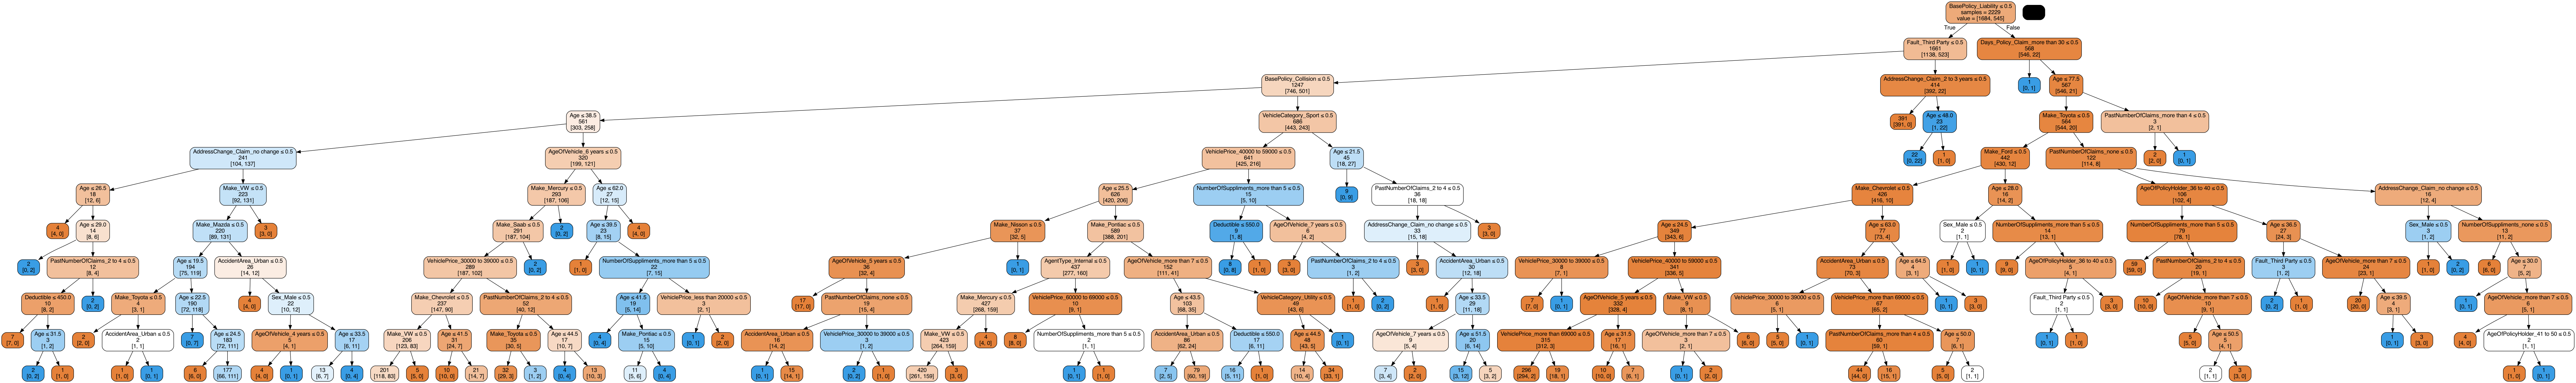

In [187]:
plotDecisionTree(classTree1, feature_names=train_X.columns)

In [188]:
# Five-fold cross-validation of the full decision tree classifier
treeClassifier = DecisionTreeClassifier()

scores = cross_val_score(treeClassifier, train_X, train_y, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})')

Accuracy scores of each fold:  ['0.713', '0.709', '0.733', '0.744', '0.726']
Accuracy: 0.725 (+/- 0.026)
Accuracy: 0.725 (+/- 0.013)


## Grid Search

In [189]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [20, 40, 60, 80, 100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1) #n_jobs=-1 means
        #that the availalbe computer memory (CPU) will be used to make calculations faster.
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.7752295057187485
Initial parameters:  {'max_depth': 20, 'min_impurity_decrease': 0.001, 'min_samples_split': 40}


In [190]:
# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(15, 25)),
    'min_samples_split': list(range(30,50)),
    'min_impurity_decrease': [0.0001, 0.0002, 0.001, 0.005, 0.01],
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Improved score:  0.7752295057187485
Improved parameters:  {'max_depth': 15, 'min_impurity_decrease': 0.001, 'min_samples_split': 41}


In [192]:
# Confusion Matrix for BestClassTree
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.7598)

       Prediction
Actual    0    1
     0 1036  112
     1  245   93


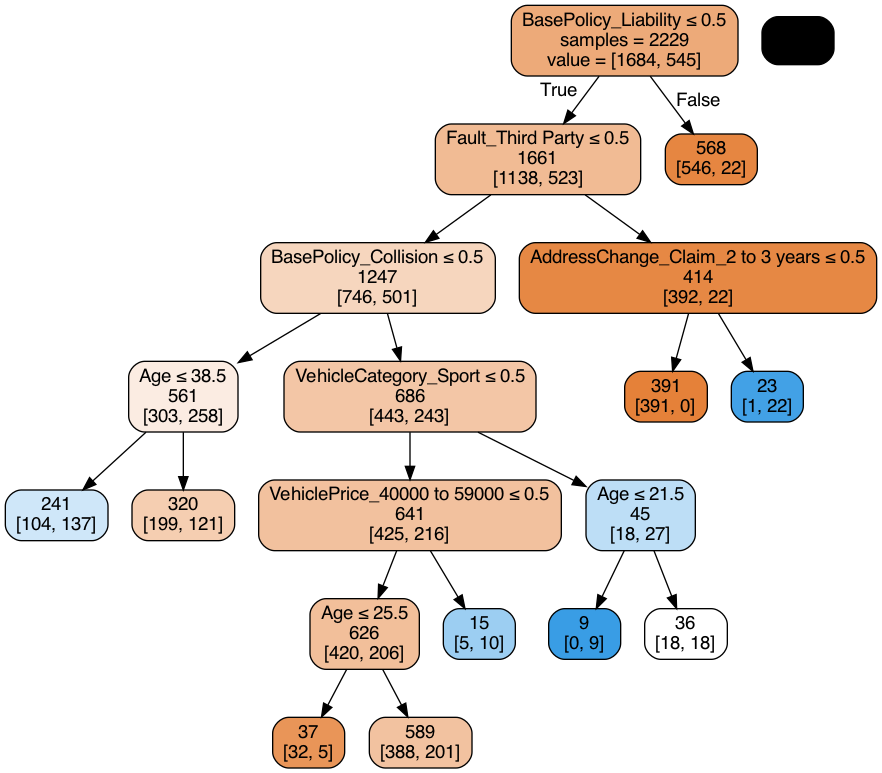

In [193]:
plotDecisionTree(bestClassTree, feature_names=train_X.columns)

## Random Forest

In [194]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [195]:
rf_importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': rf_importances, 'std': std})
df = df.sort_values('importance', ascending=False)
print(df)

                               feature  importance       std
0                                  Age    0.170961  0.019387
18                   Fault_Third Party    0.085019  0.018460
55                BasePolicy_Liability    0.044226  0.032356
19               VehicleCategory_Sport    0.037154  0.028141
54                BasePolicy_Collision    0.033241  0.016215
49            NumberOfSuppliments_none    0.032613  0.009487
30             PastNumberOfClaims_none    0.031440  0.011775
28           PastNumberOfClaims_2 to 4    0.028786  0.009978
48     NumberOfSuppliments_more than 5    0.026859  0.008960
11                        Make_Pontiac    0.025295  0.007871
21         VehiclePrice_30000 to 39000    0.025206  0.009303
14                         Make_Toyota    0.024743  0.007653
35                AgeOfVehicle_7 years    0.022105  0.007957
16                  AccidentArea_Urban    0.021966  0.008517
47          NumberOfSuppliments_3 to 5    0.021774  0.007063
17                      

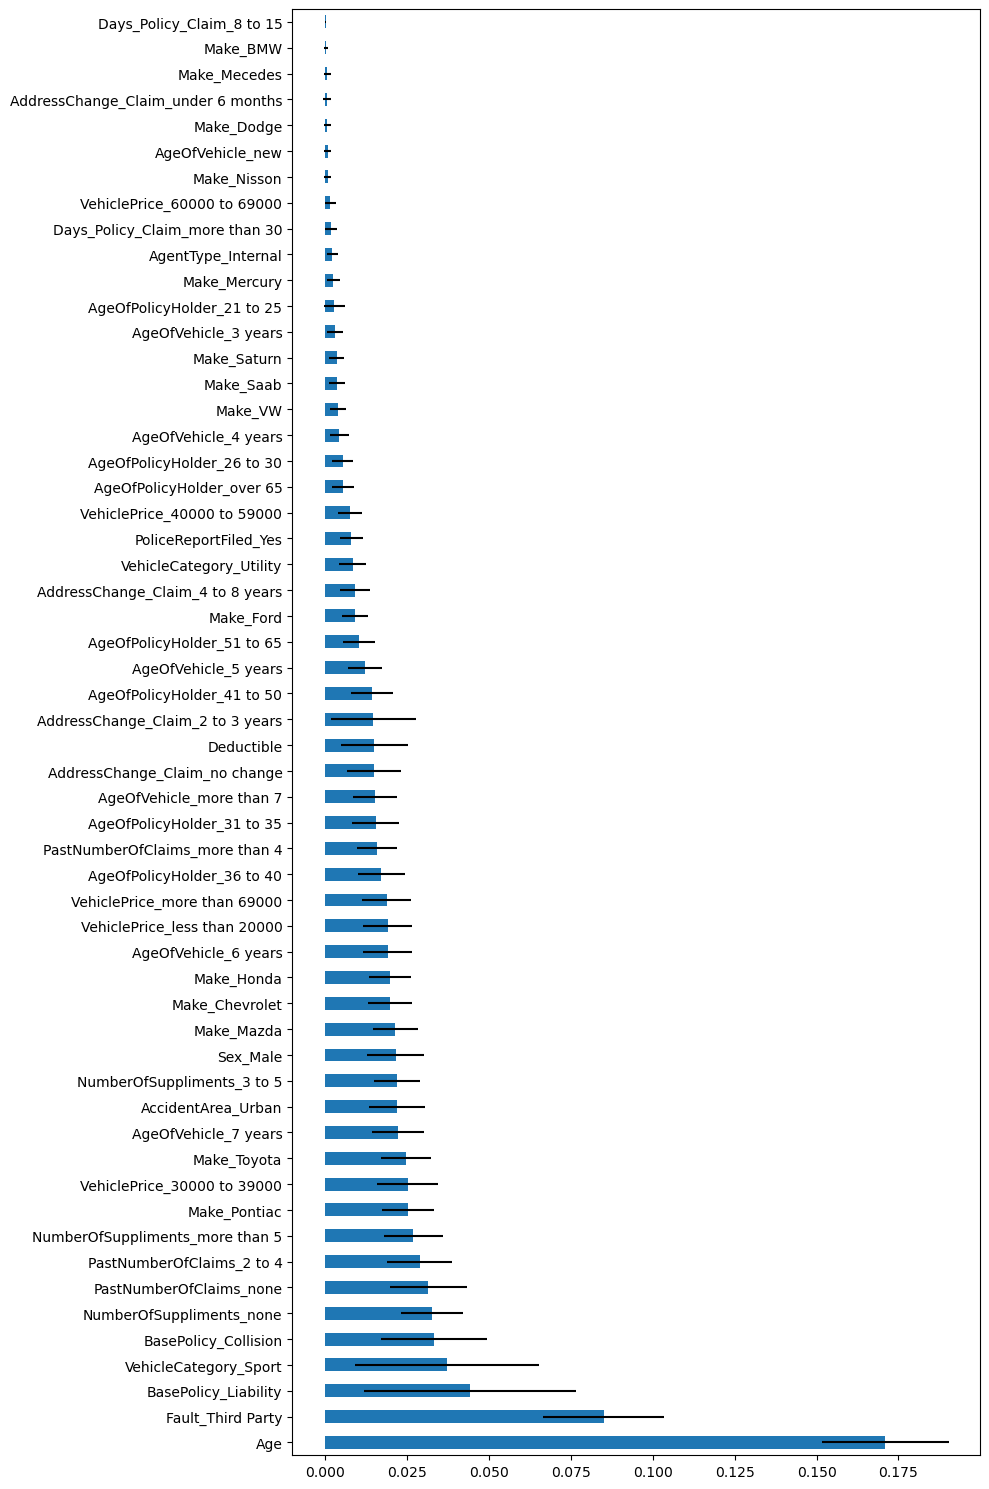

In [196]:
ax = df.plot(kind='barh', xerr='std', x='feature', legend=False, figsize=(10,15))
ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [197]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.7571)

       Prediction
Actual    0    1
     0 1028  120
     1  241   97


## Boosted Trees

In [198]:
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.7692)

       Prediction
Actual    0    1
     0 1067   81
     1  262   76


In [199]:
boost_importances = boost.feature_importances_

df = pd.DataFrame({'feature': train_X.columns, 'importance': boost_importances})
df = df.sort_values('importance',ascending=False)
print(df)

                               feature  importance
18                   Fault_Third Party    0.292688
55                BasePolicy_Liability    0.247012
50    AddressChange_Claim_2 to 3 years    0.151814
0                                  Age    0.074020
54                BasePolicy_Collision    0.033280
19               VehicleCategory_Sport    0.012948
45               PoliceReportFiled_Yes    0.009469
14                         Make_Toyota    0.008853
40          AgeOfPolicyHolder_31 to 35    0.008368
24        VehiclePrice_less than 20000    0.008331
49            NumberOfSuppliments_none    0.008259
20             VehicleCategory_Utility    0.008093
21         VehiclePrice_30000 to 39000    0.008023
42          AgeOfPolicyHolder_41 to 50    0.007851
47          NumberOfSuppliments_3 to 5    0.007510
16                  AccidentArea_Urban    0.007267
29      PastNumberOfClaims_more than 4    0.006577
17                            Sex_Male    0.006286
5                            Ma

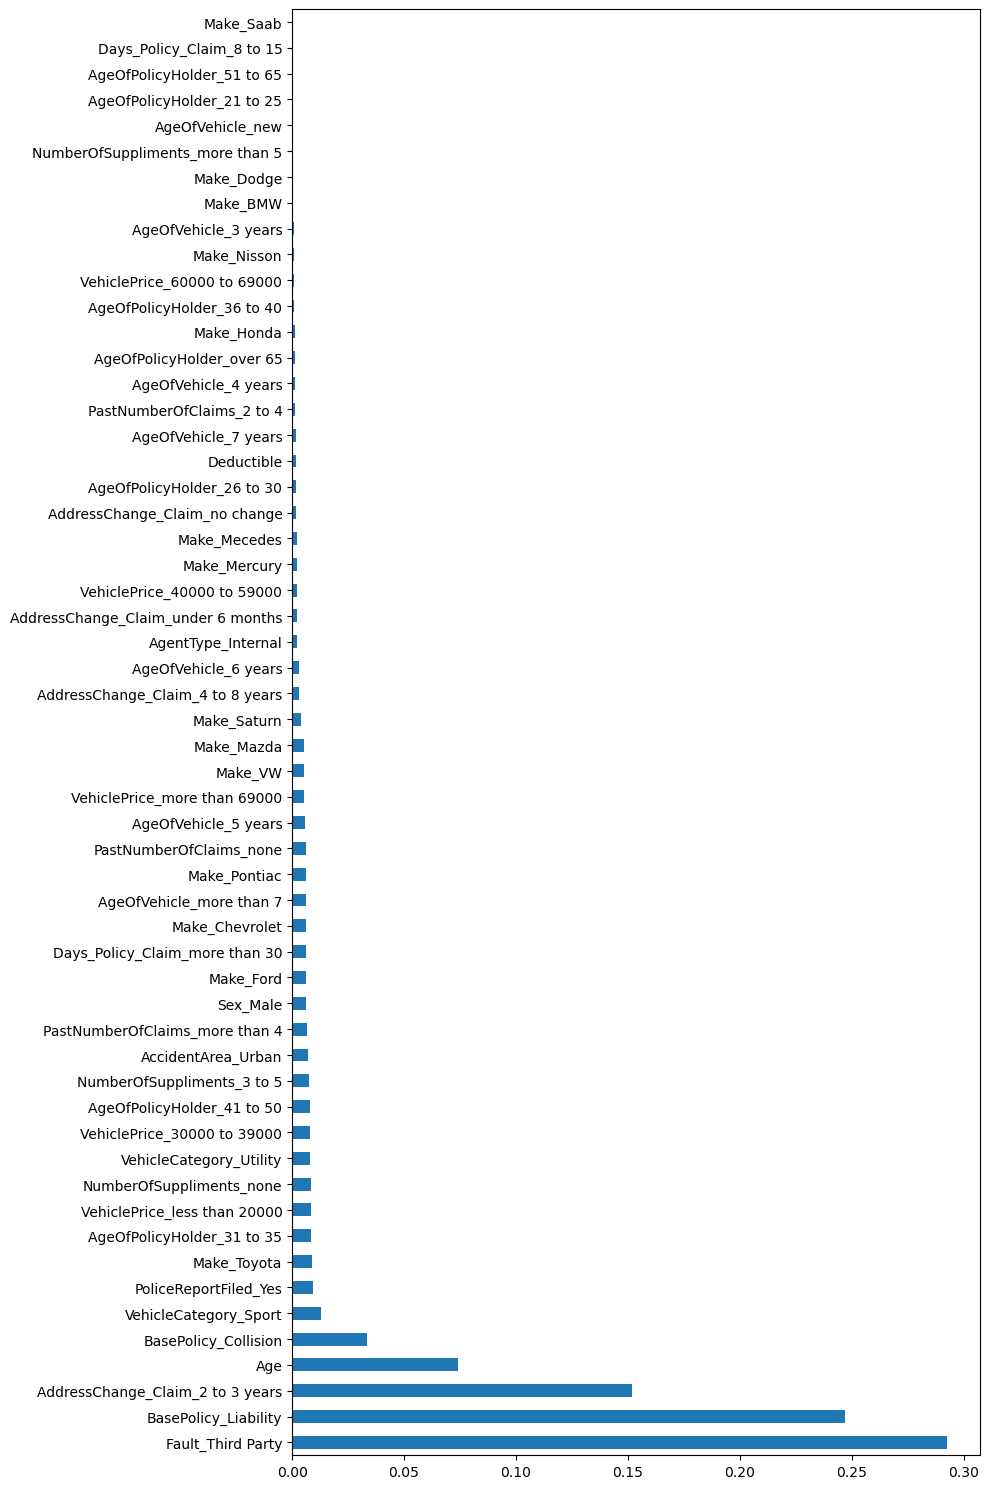

In [200]:
ax = df.plot(kind='barh', x='feature', legend=False,figsize=(10,15))
ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [202]:
# Confusion Matrix
cm1 = [[1009, 139], [228, 110]]
cmgrid = [[1036, 112], [245, 93]]
cmrf = [[1028, 120], [241, 97]]
cmboost = [[1067, 81], [262, 76]]

# For conf_matrix
TP1 = cm1[1][1]
FN1 = cm1[1][0]
TN1 = cm1[0][0]
FP1 = cm1[0][1]


# For conf_matrix_grid
TPgrid = cmgrid[1][1]
FNgrid = cmgrid[1][0]
TNgrid = cmgrid[0][0]
FPgrid = cmgrid[0][1]

# For conf_matrix_rf
TPrf = cmrf[1][1]
FNrf = cmrf[1][0]
TNrf = cmrf[0][0]
FPrf = cmrf[0][1]

# For conf_matrix_boost
TPboost = cmboost[1][1]
FNboost = cmboost[1][0]
TNboost = cmboost[0][0]
FPboost = cmboost[0][1]

TP1_pct = (TP1 / (TP1 + FN1)) * 100
TPgrid_pct = (TPgrid / (TPgrid + FNgrid)) * 100
TPrf_pct = (TPrf / (TPrf + FNrf)) * 100
TPboost_pct = (TPboost / (TPboost + FNboost)) * 100

TN1_pct = (TN1 / (TN1 + FP1)) * 100
TNgrid_pct = (TNgrid / (TNgrid + FPgrid)) * 100
TNrf_pct = (TNrf / (TNrf + FPrf)) * 100
TNboost_pct = (TNboost / (TNboost + FPboost)) * 100

# Define the headers and data for the table
headers = headers = ['Confusion Matrix', 'Sensitivity (%)', 'Specificity (%)', 'Overall Accuracy (%)']
data = [    ['CM_Class', '{:.2f}%'.format(TP1_pct),'{:.2f}%'.format(TN1_pct), '{:.2f}%'.format((cm1[0][0] + cm1[1][1])/(cm1[0][0] + cm1[0][1] + cm1[1][0] + cm1[1][1]) * 100)],
    ['CM_Grid', '{:.2f}%'.format(TPgrid_pct), '{:.2f}%'.format(TNgrid_pct),'{:.2f}%'.format((cmgrid[0][0] + cmgrid[1][1])/(cmgrid[0][0] + cmgrid[0][1] + cmgrid[1][0] + cmgrid[1][1])* 100)],
    ['CM_RF', '{:.2f}%'.format(TPrf_pct),'{:.2f}%'.format(TNrf_pct), '{:.2f}%'.format((cmrf[0][0] + cmrf[1][1])/(cmrf[0][0] + cmrf[0][1] + cmrf[1][0] + cmrf[1][1]) * 100)],
    ['CM_Boost', '{:.2f}%'.format(TPboost_pct), '{:.2f}%'.format(TNboost_pct),'{:.2f}%'.format((cmboost[0][0] + cmboost[1][1] )/(cmboost[0][0] + cmboost[0][1] + cmboost[1][0] + cmboost[1][1])* 100)]
]

# Create the table and set the headers
table = PrettyTable()
table.field_names = headers

# Add the data to the table
for row in data:
    table.add_row(row)

# Print the table
print(table)

+------------------+-----------------+-----------------+----------------------+
| Confusion Matrix | Sensitivity (%) | Specificity (%) | Overall Accuracy (%) |
+------------------+-----------------+-----------------+----------------------+
|     CM_Class     |      32.54%     |      87.89%     |        75.30%        |
|     CM_Grid      |      27.51%     |      90.24%     |        75.98%        |
|      CM_RF       |      28.70%     |      89.55%     |        75.71%        |
|     CM_Boost     |      22.49%     |      92.94%     |        76.92%        |
+------------------+-----------------+-----------------+----------------------+


## Logit Regression

In [203]:
# Fit a logistic regression
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

# Get intercepts, coefficients, and AIC
print('Intercept:', logit_reg.intercept_[0])
coefficients = pd.DataFrame({'Coefficients': logit_reg.coef_[0]}, index=X.columns)
coefficients_sorted = coefficients.sort_values(by='Coefficients', ascending=False)
print(coefficients_sorted.to_string())
print('AIC:', AIC_score(valid_y, logit_reg.predict(valid_X), df=len(train_X.columns) + 1))

Intercept: 0.14303353035171507
                                    Coefficients
AddressChange_Claim_2 to 3 years        2.843500
VehicleCategory_Sport                   0.945941
AgeOfVehicle_5 years                    0.759387
AgeOfVehicle_4 years                    0.680797
VehiclePrice_40000 to 59000             0.646559
AgeOfVehicle_6 years                    0.551999
AgeOfVehicle_7 years                    0.462236
AddressChange_Claim_under 6 months      0.430740
PastNumberOfClaims_more than 4          0.391439
Make_Mecedes                            0.371689
PastNumberOfClaims_2 to 4               0.334967
VehiclePrice_60000 to 69000             0.322609
Sex_Male                                0.300622
PastNumberOfClaims_none                 0.230015
AgeOfPolicyHolder_21 to 25              0.212426
VehiclePrice_more than 69000            0.208350
AgeOfPolicyHolder_over 65               0.200528
AgeOfVehicle_more than 7                0.199215
VehiclePrice_less than 20000          

In [204]:
# Use the classification summary function for validation data
logit_reg_pred = logit_reg.predict(valid_X)
classificationSummary(valid_y, logit_reg_pred)

Confusion Matrix (Accuracy 0.7739)

       Prediction
Actual    0    1
     0 1061   87
     1  249   89


In [205]:
# Confusion Matrix
cmlogit = [[1064, 87], [249, 89]]


# For conf_matrix1
TPlogit = cmlogit[1][1]
FNlogit = cmlogit[1][0]
TNlogit = cmlogit[0][0]
FPlogit = cmlogit[0][1]

TPlogit_pct = (TPlogit / (TPlogit + FNlogit)) * 100
TNlogit_pct = (TNlogit / (TNlogit + FPlogit)) * 100

# Define the headers and data for the table
headers = ['Confusion Matrix', 'Sensitivity (%)','Specificity (%)','Total Accuracy (%)']
data = [    ['CM_Logit', '{:.2f}%'.format(TPlogit_pct), '{:.2f}%'.format(TNlogit_pct),'{:.2f}%'.format((cmlogit[0][0] + cmlogit[1][1])/(cmlogit[0][0] + cmlogit[0][1] + cmlogit[1][0] + cmlogit[1][1]) * 100)]

]

# Create the table and set the headers
table = PrettyTable()
table.field_names = headers

# Add the data to the table
for row in data:
    table.add_row(row)

# Print the table
print(table)

+------------------+-----------------+-----------------+--------------------+
| Confusion Matrix | Sensitivity (%) | Specificity (%) | Total Accuracy (%) |
+------------------+-----------------+-----------------+--------------------+
|     CM_Logit     |      26.33%     |      92.44%     |       77.43%       |
+------------------+-----------------+-----------------+--------------------+


In [206]:
# Backward elimination
def train_model(variables):
    model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    model.fit(train_X, train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X), model)

bestBE_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age, Deductible, Make_BMW, Make_Chevrolet, Make_Dodge, Make_Ford, Make_Honda, Make_Mazda, Make_Mecedes, Make_Mercury, Make_Nisson, Make_Pontiac, Make_Saab, Make_Saturn, Make_Toyota, Make_VW, AccidentArea_Urban, Sex_Male, Fault_Third Party, VehicleCategory_Sport, VehicleCategory_Utility, VehiclePrice_30000 to 39000, VehiclePrice_40000 to 59000, VehiclePrice_60000 to 69000, VehiclePrice_less than 20000, VehiclePrice_more than 69000, Days_Policy_Claim_8 to 15, Days_Policy_Claim_more than 30, PastNumberOfClaims_2 to 4, PastNumberOfClaims_more than 4, PastNumberOfClaims_none, AgeOfVehicle_3 years, AgeOfVehicle_4 years, AgeOfVehicle_5 years, AgeOfVehicle_6 years, AgeOfVehicle_7 years, AgeOfVehicle_more than 7, AgeOfVehicle_new, AgeOfPolicyHolder_21 to 25, AgeOfPolicyHolder_26 to 30, AgeOfPolicyHolder_31 to 35, AgeOfPolicyHolder_36 to 40, AgeOfPolicyHolder_41 to 50, AgeOfPolicyHolder_51 to 65, AgeOfPolicyHolder_over 65, PoliceReportFiled_Yes, AgentType_Internal, NumberOfSuppliments

In [207]:
regressionSummary(valid_y, bestBE_model.predict(valid_X[best_variables]))


Regression statistics

               Mean Error (ME) : 0.1090
Root Mean Squared Error (RMSE) : 0.4755
     Mean Absolute Error (MAE) : 0.2261


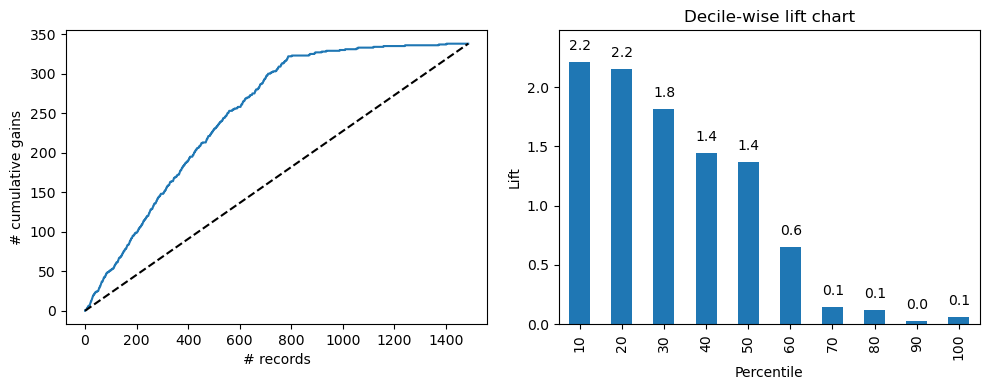

In [208]:
logit_reg_predBE = bestBE_model.predict(valid_X[best_variables])
logit_reg_proba = bestBE_model.predict_proba(valid_X[best_variables])
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_predBE })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title='Decile-wise lift chart', ax=axes[1])

plt.tight_layout()
plt.show()

# MLP

In [209]:
print(train_X.columns)

Index(['Age', 'Deductible', 'Make_BMW', 'Make_Chevrolet', 'Make_Dodge',
       'Make_Ford', 'Make_Honda', 'Make_Mazda', 'Make_Mecedes', 'Make_Mercury',
       'Make_Nisson', 'Make_Pontiac', 'Make_Saab', 'Make_Saturn',
       'Make_Toyota', 'Make_VW', 'AccidentArea_Urban', 'Sex_Male',
       'Fault_Third Party', 'VehicleCategory_Sport', 'VehicleCategory_Utility',
       'VehiclePrice_30000 to 39000', 'VehiclePrice_40000 to 59000',
       'VehiclePrice_60000 to 69000', 'VehiclePrice_less than 20000',
       'VehiclePrice_more than 69000', 'Days_Policy_Claim_8 to 15',
       'Days_Policy_Claim_more than 30', 'PastNumberOfClaims_2 to 4',
       'PastNumberOfClaims_more than 4', 'PastNumberOfClaims_none',
       'AgeOfVehicle_3 years', 'AgeOfVehicle_4 years', 'AgeOfVehicle_5 years',
       'AgeOfVehicle_6 years', 'AgeOfVehicle_7 years',
       'AgeOfVehicle_more than 7', 'AgeOfVehicle_new',
       'AgeOfPolicyHolder_21 to 25', 'AgeOfPolicyHolder_26 to 30',
       'AgeOfPolicyHolder_31 to 35

In [210]:
clf = MLPClassifier(hidden_layer_sizes=(30,120,59), activation='relu', solver='adam', random_state=1)
clf.fit(train_X, train_y)
clf.predict(valid_X)

# Network structure
print('Intercepts')
print(clf.intercepts_)

print('Weights')
print(clf.coefs_)

# Prediction
print(pd.concat([train_X, pd.DataFrame(clf.predict_proba(train_X))
                    ], axis=1))

Intercepts
[array([-0.21637448, -0.2019157 , -0.22869067, -0.16163519, -0.19878839,
        0.12689575, -0.23516625, -0.14532667,  0.20024961,  0.23837423,
        0.02069529,  0.23477277, -0.2411811 ,  0.22578677, -0.09968672,
        0.14877678,  0.13980552,  0.17134056, -0.02189639,  0.22375676,
       -0.127898  ,  0.20327146,  0.04710947,  0.25019907, -0.24005018,
        0.11894891,  0.02192476, -0.00400215, -0.14128705, -0.09784389]), array([-8.35969113e-03, -1.09569496e-01, -4.14608772e-02, -1.44036374e-01,
        1.49901772e-01, -1.88569458e-01,  2.24450046e-02, -1.64493345e-01,
       -9.32048404e-02, -1.66469798e-01, -9.06341670e-05,  4.09424777e-02,
        1.38559460e-01, -3.31635013e-02,  9.50577852e-02,  2.19764315e-02,
        1.86722541e-01, -1.52113682e-01,  1.33405356e-01,  1.22641680e-01,
        1.03256806e-01, -2.49029513e-02,  7.50451539e-03,  1.89086724e-01,
        1.56955631e-01,  9.69000361e-02, -1.58954664e-02,  1.49910537e-02,
        1.28676671e-01, -9.59

In [211]:
classificationSummary(valid_y,clf.predict(valid_X))

Confusion Matrix (Accuracy 0.7699)

       Prediction
Actual    0    1
     0 1121   27
     1  315   23


In [212]:
# Confusion Matrix
cmmlp = [[1121, 27], [315, 23]]


# For conf_matrix1
TPmlp = cmmlp[1][1]
FNmlp = cmmlp[1][0]
TNmlp = cmmlp[0][0]
FPmlp = cmmlp[0][1]

TPmlp_pct = (TPmlp / (TPmlp + FNmlp)) * 100
TNmlp_pct = (TNmlp / (TNmlp + FPmlp)) * 100

# Define the headers and data for the table
headers = ['Confusion Matrix', 'Sensitivity (%)','Specificity (%)','Total Accuracy (%)']
data = [    ['CM_MLP', '{:.2f}%'.format(TPmlp_pct), '{:.2f}%'.format(TNmlp_pct),'{:.2f}%'.format((cmmlp[0][0] + cmmlp[1][1])/(cmmlp[0][0] + cmmlp[0][1] + cmmlp[1][0] + cmmlp[1][1]) * 100)]

]

# Create the table and set the headers
table = PrettyTable()
table.field_names = headers

# Add the data to the table
for row in data:
    table.add_row(row)

# Print the table
print(table)

+------------------+-----------------+-----------------+--------------------+
| Confusion Matrix | Sensitivity (%) | Specificity (%) | Total Accuracy (%) |
+------------------+-----------------+-----------------+--------------------+
|      CM_MLP      |      6.80%      |      97.65%     |       76.99%       |
+------------------+-----------------+-----------------+--------------------+


# Confusion Matrix for All Models


In [213]:
headers = ['Confusion Matrix', 'Sensitivity (%)','Specificity (%)','Total Accuracy (%)']
data = [['cmocsvm', 
         '{:.2f}%'.format(TPocsvm), 
         '{:.2f}%'.format(TNocsvm),
         '{:.2f}%'.format((cmocsvm[0][0] + cmocsvm[1][1])/(cmocsvm[0][0] + cmocsvm[0][1] + cmocsvm[1][0] + cmocsvm[1][1]) * 100)],['cmif', 
         '{:.2f}%'.format(TPif), 
         '{:.2f}%'.format(TNif),
         '{:.2f}%'.format((cmif[0][0] + cmif[1][1])/(cmif[0][0] + cmif[0][1] + cmif[1][0] + cmif[1][1]) * 100)],['CM_Class', '{:.2f}%'.format(TP1_pct),'{:.2f}%'.format(TN1_pct), '{:.2f}%'.format((cm1[0][0] + cm1[1][1])/(cm1[0][0] + cm1[0][1] + cm1[1][0] + cm1[1][1]) * 100)],
    ['CM_Grid', '{:.2f}%'.format(TPgrid_pct), '{:.2f}%'.format(TNgrid_pct),'{:.2f}%'.format((cmgrid[0][0] + cmgrid[1][1])/(cmgrid[0][0] + cmgrid[0][1] + cmgrid[1][0] + cmgrid[1][1])* 100)],
    ['CM_RF', '{:.2f}%'.format(TPrf_pct),'{:.2f}%'.format(TNrf_pct), '{:.2f}%'.format((cmrf[0][0] + cmrf[1][1])/(cmrf[0][0] + cmrf[0][1] + cmrf[1][0] + cmrf[1][1]) * 100)],
    ['CM_Boost', '{:.2f}%'.format(TPboost_pct), '{:.2f}%'.format(TNboost_pct),'{:.2f}%'.format((cmboost[0][0] + cmboost[1][1] )/(cmboost[0][0] + cmboost[0][1] + cmboost[1][0] + cmboost[1][1])* 100)],
['CM_Logit', '{:.2f}%'.format(TPlogit_pct), '{:.2f}%'.format(TNlogit_pct),'{:.2f}%'.format((cmlogit[0][0] + cmlogit[1][1])/(cmlogit[0][0] + cmlogit[0][1] + cmlogit[1][0] + cmlogit[1][1]) * 100)],
       ['CM_MLP', '{:.2f}%'.format(TPmlp_pct), '{:.2f}%'.format(TNmlp_pct),'{:.2f}%'.format((cmmlp[0][0] + cmmlp[1][1])/(cmmlp[0][0] + cmmlp[0][1] + cmmlp[1][0] + cmmlp[1][1]) * 100)]]

# Create the table and set the headers
table = PrettyTable()
table.field_names = headers

# Add the data to the table
for row in data:
    table.add_row(row)

# Print the table
print(table)

+------------------+-----------------+-----------------+--------------------+
| Confusion Matrix | Sensitivity (%) | Specificity (%) | Total Accuracy (%) |
+------------------+-----------------+-----------------+--------------------+
|     cmocsvm      |      2.08%      |      98.87%     |       93.47%       |
|       cmif       |      19.64%     |      83.47%     |       79.91%       |
|     CM_Class     |      32.54%     |      87.89%     |       75.30%       |
|     CM_Grid      |      27.51%     |      90.24%     |       75.98%       |
|      CM_RF       |      28.70%     |      89.55%     |       75.71%       |
|     CM_Boost     |      22.49%     |      92.94%     |       76.92%       |
|     CM_Logit     |      26.33%     |      92.44%     |       77.43%       |
|      CM_MLP      |      6.80%      |      97.65%     |       76.99%       |
+------------------+-----------------+-----------------+--------------------+


### One class SVM model has the highest total accuracy and specificity. Classifiction Tree has the highest sensitivity.  